In [1]:
import pandas as pd
import time
from nltk.corpus import wordnet
from nltk import pos_tag
import matplotlib.pyplot as plt 
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
import string
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import classification_report
import math

In [2]:
def cosine_sim(vec1, vec2):
    # vec1 = list(vec1.values())
    # vec2 = list(vec2.values())
    dot_prod = 0
    for i, v in enumerate(vec1):
        dot_prod += v * vec2[i]
    mag_1 = math.sqrt(sum([x**2 for x in vec1]))
    mag_2 = math.sqrt(sum([x**2 for x in vec2]))
    return dot_prod / (mag_1 * mag_2)

In [3]:
def split_train_test(top_data_df_small, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(top_data_df_small[['review', 'stars']], 
                                                        top_data_df_small['stars'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

In [4]:
def map_stars(stars_received):
    if stars_received  == 5:
        return 5
    elif stars_received >= 4:
        return 4
    elif stars_received >= 3:
        return 3
    elif stars_received >= 2:
        return 2
    else:
        return 1

                                              review  stars
0   I am so angry that i made this post available...   1.45
1  No Negative No real complaints the hotel was g...   3.75
2   Rooms are nice but for elderly a bit difficul...   3.55
3   My room was dirty and I was afraid to walk ba...   1.90
4   You When I booked with your company on line y...   3.35
Index(['review', 'stars'], dtype='object')
4    219793
3    127585
5    115853
2     41779
1     10728
Name: stars, dtype: int64
                                              review  stars
0   I am so angry that i made this post available...      1
1   No real complaints the hotel was great great ...      3
2   Rooms are nice but for elderly a bit difficul...      3
3   My room was dirty and I was afraid to walk ba...      1
4   You When I booked with your company on line y...      3


Text(0, 0.5, 'No. of rows in df')

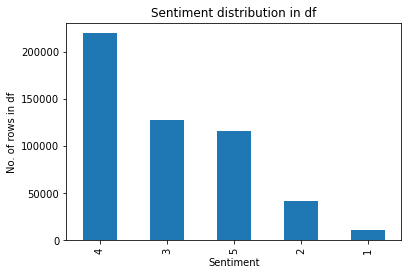

In [5]:
# read data
reviews_df = pd.read_csv("Hotel_Reviews.csv")
# append the positive and negative text reviews
reviews_df["review"] = reviews_df["Negative_Review"] + reviews_df["Positive_Review"]
reviews_df["stars"] = reviews_df["Reviewer_Score"].apply(lambda x: x/2)
# reviews_df['stars'] = reviews_df['stars'].replace([1,2,3,4,5], ['1', '2','3','4','5'])
# reviews_df["stars"] = reviews_df["Reviewer_Score"]   
reviews_df = reviews_df[["review", "stars"]]
print(reviews_df.head())
# reviews_df
# remove 'No Negative' or 'No Positive' from text
reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))
# reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))
print(reviews_df.columns)
# print("Number of rows per star rating:")
# print(reviews_df['stars'].value_counts())
# print(reviews_df['stars'].value_counts())
reviews_df['stars'] = [map_stars(x) for x in reviews_df['stars']]    
# reviews_df['stars'] = reviews_df['stars'].replace([1,2,3,4,5], ['1', '2','3','4','5'])
print(reviews_df['stars'].value_counts())
print(reviews_df.head())
plt.figure()
pd.value_counts(reviews_df['stars']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
# plt.show()

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
top_data_df_5star = reviews_df[reviews_df['stars'] == 5].head(10000)
top_data_df_4star = reviews_df[reviews_df['stars'] == 4].head(10000)
top_data_df_3star = reviews_df[reviews_df['stars'] == 3].head(10000)
top_data_df_2star = reviews_df[reviews_df['stars'] == 2].head(10000)
top_data_df_1star = reviews_df[reviews_df['stars'] == 1].head(10000)

top_data_df_small = pd.concat([top_data_df_5star, top_data_df_4star, top_data_df_3star, 
                               top_data_df_2star, top_data_df_1star])


In [8]:
# After selecting top few samples of each sentiment
print("After segregating and taking equal number of rows for each sentiment:")
print(top_data_df_small['stars'].value_counts())
top_data_df_small.head(10)
X_train, X_test, Y_train, Y_test = split_train_test(top_data_df_small)
# top_data_df_small['review'] = top_data_df_small.groupby(['stars'])['review'].transform(lambda x : ' '.join(x))
# top_data_df_small = top_data_df_small.drop_duplicates()
top_data_df_small['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in top_data_df_small['review']] 

print(top_data_df_small.head(20))

After segregating and taking equal number of rows for each sentiment:
5    10000
4    10000
3    10000
2    10000
1    10000
Name: stars, dtype: int64
Value counts for Train sentiments
2    7045
3    7023
1    6985
4    6975
5    6972
Name: stars, dtype: int64
Value counts for Test sentiments
5    3028
4    3025
1    3015
3    2977
2    2955
Name: stars, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
    index                                             review  stars
0   70888   This is not a 4 stars hotel Very old furnitur...      2
1   19442   I love the greeting that was always given whe...      5
2  305893   Customer services was very poor attitude was ...      1
3   92431   Very small room if you compared with the valu...      2
4   13267   Room size For a four star hotel the room size...      2
                                                review  stars  \
7     Apart from the price for the brekfast Everyth...      5   
10    Nothing all 

In [9]:
porter_stemmer = PorterStemmer()
top_data_df_small['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in top_data_df_small['tokenized_text'] ]
print("top_data columns:")
print(top_data_df_small.columns)

top_data columns:
Index(['review', 'stars', 'tokenized_text', 'stemmed_tokens'], dtype='object')


In [10]:
# TaggedDocuments are tuple of stemmed_tokens and class lable, example is printed (scroll to the right to see label)
# documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(top_data_df_small['stemmed_tokens'])]
documents=[]
for index, row in top_data_df_small.iterrows():
    label=row['stars']
    documents.append(TaggedDocument(row['stemmed_tokens'],[label]))
print(documents[1])

TaggedDocument(['noth', 'all', 'great', 'room', 'were', 'stunningli', 'decor', 'and', 'realli', 'spaciou', 'in', 'the', 'top', 'of', 'the', 'build', 'pictur', 'ar', 'of', 'room', 'the', 'true', 'beauti', 'of', 'the', 'build', 'ha', 'been', 'kept', 'but', 'modernis', 'brilliantli', 'also', 'the', 'bath', 'wa', 'love', 'and', 'big', 'and', 'invit', 'great', 'more', 'for', 'coupl', 'restaur', 'menu', 'wa', 'bit', 'pricei', 'but', 'there', 'were', 'load', 'of', 'littl', 'eateri', 'place', 'nearbi', 'within', 'walk', 'distanc', 'and', 'the', 'tram', 'stop', 'into', 'the', 'centr', 'wa', 'about', 'minut', 'walk', 'awai', 'and', 'onli', 'about', 'or', 'stop', 'from', 'the', 'centr', 'of', 'amsterdam', 'would', 'recommend', 'thi', 'hotel', 'to', 'anyon', 'it', 'unbeliev', 'well', 'price', 'too'], [5])


In [11]:
# Initialize the model
start_time = time.time()
doc2vec_model = Doc2Vec(documents, vector_size=1000, window=5, min_count=1, workers=4)
five_vector = doc2vec_model.docvecs[5]
five_vector
fourth_vector = doc2vec_model.docvecs[4]
third_vector = doc2vec_model.docvecs[3]
second_vector = doc2vec_model.docvecs[2]
first_vector = doc2vec_model.docvecs[1]
print("Time taken to create doc2vec vectors: " + str(time.time() - start_time))

Time taken to create doc2vec vectors: 83.46195912361145


C:\Users\hp\AppData\Local\Temp\ipykernel_10708\2187857776.py:4: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  five_vector = doc2vec_model.docvecs[5]
C:\Users\hp\AppData\Local\Temp\ipykernel_10708\2187857776.py:6: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  fourth_vector = doc2vec_model.docvecs[4]
C:\Users\hp\AppData\Local\Temp\ipykernel_10708\2187857776.py:7: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  third_vector = doc2vec_model.docvecs[3]
C:\Users\hp\AppData\Local\Temp\ipykernel_10708\2187857776.py:8: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  second_vector = doc2vec_model.docvecs[2]
C:\Users\hp\AppData\Local\Temp\ipykernel_10708\2187857776.py:9: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  first_vector = doc2

In [12]:
# Sample vector for the stemmed tokens
# vector = doc2vec_model.infer_vector(top_data_df_small['stemmed_tokens'][0])
# # Printing sample vector
# print(len(vector))
# print("Top 10 values in Doc2Vec inferred vector:")
# print(vector[:10])

In [13]:
# start_time = time.time()
# star_features_doc2vec = []
# doc2vec_filename = 'train_review_doc2vec.csv'
# with open(doc2vec_filename, 'w+') as doc2vec_file:
#     header = ",".join(str(ele) for ele in range(10000))
#     doc2vec_file.write(header)
#     doc2vec_file.write("\n")
#     for index, row in top_data_df_small.iterrows():

#         model_vector = doc2vec_model.infer_vector(row['stemmed_tokens'])
#         star_features_doc2vec.append(model_vector)
#         # if index == 0:
#         #     header = ",".join(str(ele) for ele in range(1000))
#         #     doc2vec_file.write(header)
#         #     doc2vec_file.write("\n")
#         #     # star_features_doc2vec.append(model_vector)
#         line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
#         doc2vec_file.write(line1)
#         doc2vec_file.write('\n')
# print("Time taken to create doc2vec vectors: " + str(time.time() - start_time))
# print("star vectors:")
# print(star_features_doc2vec)

In [14]:
X_test['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in X_test['review']] 
X_test['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in X_test['tokenized_text']]

documents2 = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_test['stemmed_tokens'])]
doc2vec_model2 = Doc2Vec(documents2, vector_size=1000, window=7, min_count=1, workers=4, epochs = 20)

In [15]:
# #Testing the model on the test data
test_features_doc2vec = []
for index, row in X_test.iterrows():
    model_vector = doc2vec_model2.infer_vector(row['stemmed_tokens'])
    test_features_doc2vec.append(model_vector)
# test_predictions_doc2vec = clf_decision_doc2vec.predict(test_features_doc2vec)
# print(classification_report(Y_test['stars'],test_predictions_doc2vec))
X_test.to_csv("file4.csv")

In [16]:
rating = {5:[],4:[],3:[],2:[],1:[]}
for i in range(10000):
#check cosine similarity of test data with the 5 classes doc2vec
    score5 = cosine_sim(test_features_doc2vec[i], five_vector)
    rating[5].append(score5)
    score4 = cosine_sim(test_features_doc2vec[i], fourth_vector)
    rating[4].append(score4)
    score3 = cosine_sim(test_features_doc2vec[i], third_vector)
    rating[3].append(score3)
    score2 = cosine_sim(test_features_doc2vec[i], second_vector)
    rating[2].append(score2)
    score1 = cosine_sim(test_features_doc2vec[i], first_vector)
    rating[1].append(score1)
Y_test.to_csv("file3.csv")
# score = cosine_sim(test_features_doc2vec[1], star_features_doc2vec[5])

In [17]:
print(rating)

{5: [-0.023342713113314466, -0.03278963915092455, -0.017746665299831852, -0.05883855221009614, -0.0019799061096845228, 0.006568535607591741, -0.0757343316209826, -0.005003658564381302, 0.00015502161921404766, -0.0209999824296507, 0.031160731637407423, -0.06560367538735139, -0.03053673784158925, -0.08069762125055277, 0.0004548952123623714, -0.022506851715680454, -0.02724535931123526, 0.029516808129183583, -0.01782567674679719, -0.11142686385274346, -0.02964649504043717, -0.09174017809776291, -0.04926432230787943, 0.00035090291672909026, 0.005524127148341171, -0.03772797014898714, -0.06930086141507463, -0.05410011330656856, -0.023121959813240427, -0.06499449492272913, -0.1209815256018076, -0.025200352467552836, -0.006863109480940686, 0.023157921841815112, -0.03739991515211785, -0.055054720436919835, -0.08285883103975807, -0.029239545019497926, -0.03316144737859301, 0.023341909568741034, -0.10949203215809493, -0.07679524943832315, -0.05667512223708052, -0.047412063122316286, -0.1040872920

In [18]:
cos_matrix = pd.DataFrame.from_dict(rating)

In [19]:
cos_matrix.head()

,5,4,3,2,1
0,-0.023343,0.005660,0.047641,0.079733,0.046214
1,-0.032790,-0.051530,0.022910,0.098907,0.082630
2,-0.017747,-0.039178,0.032788,0.129834,0.072096
3,-0.058839,-0.053067,0.062941,0.167299,0.165018
4,-0.001980,-0.001914,0.093661,0.195472,0.130739


In [20]:
max_cos = cos_matrix.idxmax(axis=1)

In [21]:
cos_matrix['pred_rating'] = max_cos
cos_matrix

,5,4,3,2,1,pred_rating
0,-0.023343,0.005660,0.047641,0.079733,0.046214,2
1,-0.032790,-0.051530,0.022910,0.098907,0.082630,2
2,-0.017747,-0.039178,0.032788,0.129834,0.072096,2
3,-0.058839,-0.053067,0.062941,0.167299,0.165018,2
4,-0.001980,-0.001914,0.093661,0.195472,0.130739,2
...,...,...,...,...,...,...
9995,-0.072274,-0.039141,0.066527,0.167693,0.171626,1
9996,0.004458,-0.013509,0.060152,0.139048,0.090895,2
9997,-0.042297,-0.031184,0.062390,0.107238,0.063688,2
9998,-0.058622,-0.041717,0.096811,0.243402,0.177868,2


In [22]:
cos_matrix['actual_rating']=Y_test['stars']
cos_matrix

,5,4,3,2,1,pred_rating,actual_rating
0,-0.023343,0.005660,0.047641,0.079733,0.046214,2,2
1,-0.032790,-0.051530,0.022910,0.098907,0.082630,2,4
2,-0.017747,-0.039178,0.032788,0.129834,0.072096,2,4
3,-0.058839,-0.053067,0.062941,0.167299,0.165018,2,1
4,-0.001980,-0.001914,0.093661,0.195472,0.130739,2,2
...,...,...,...,...,...,...,...
9995,-0.072274,-0.039141,0.066527,0.167693,0.171626,1,1
9996,0.004458,-0.013509,0.060152,0.139048,0.090895,2,5
9997,-0.042297,-0.031184,0.062390,0.107238,0.063688,2,2
9998,-0.058622,-0.041717,0.096811,0.243402,0.177868,2,2


In [23]:
def compare_results(r):
    if (abs(r['pred_rating']-r['actual_rating']))>=2:
        return 0
    else:
        return 1
cos_matrix['result']=cos_matrix.apply(compare_results, axis=1)
cos_matrix
x = sum(cos_matrix['result'])
print(x)
print(x/len(cos_matrix.index))

5763
0.5763


In [24]:
# cos_matrix['abs_error']=abs(cos_matrix['actual_rating']-cos_matrix['pred_rating'])
# print(sum(cos_matrix['abs_error'])/len(cos_matrix.index))

In [25]:
# print(classification_report(Y_test['stars'].head(10000),cos_matrix['pred_rating']))

In [27]:
user_input = "This hotel is great if you want to waste your money."
input_tokenized = simple_preprocess(user_input, deacc=True)
print(input_tokenized)
input_stemmed = [porter_stemmer.stem(word) for word in input_tokenized]
print(input_stemmed)
document3 = TaggedDocument(input_stemmed, [0])
doc2vec_model3 = Doc2Vec(documents2, vector_size=1000, window=5, min_count=1, workers=4)

test_vector = doc2vec_model3.infer_vector(input_stemmed)
score5 = cosine_sim(test_vector, five_vector)
score4 = cosine_sim(test_vector, fourth_vector)
score3 = cosine_sim(test_vector, third_vector)
score2 = cosine_sim(test_vector, second_vector)
score1 = cosine_sim(test_vector, first_vector)
print(score1)
print(score2)
print(score3)
print(score4)
print(score5)


['this', 'hotel', 'is', 'great', 'if', 'you', 'want', 'to', 'waste', 'your', 'money']
['thi', 'hotel', 'is', 'great', 'if', 'you', 'want', 'to', 'wast', 'your', 'monei']
0.16555487540332783
0.25978782661913563
0.15349046456674745
0.008478323385617206
-0.019747324308718214
